<a href="https://colab.research.google.com/github/amaddar27/Barclays-Conv-Forecasting/blob/main/Barclays_CNN_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#upload the csv
from google.colab import files
uploaded = files.upload()

In [2]:
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D,Flatten
from sklearn.cluster import KMeans

plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('BCS.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,12.63,12.86,12.58,12.85,10.933390,4131500
1,2016-01-05,12.79,12.84,12.64,12.77,10.865323,2040100
2,2016-01-06,12.39,12.50,12.36,12.42,10.567526,3033400
3,2016-01-07,12.05,12.18,11.92,11.93,10.150611,4050100
4,2016-01-08,12.02,12.05,11.66,11.68,9.937900,3254700
...,...,...,...,...,...,...,...
1408,2021-08-06,10.26,10.32,10.24,10.30,10.191321,3727900
1409,2021-08-09,10.33,10.42,10.26,10.37,10.260583,3951600
1410,2021-08-10,10.32,10.43,10.30,10.43,10.319950,3225900
1411,2021-08-11,10.46,10.54,10.42,10.52,10.409000,3458400


In [4]:
df = df.dropna()
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

print(rows_with_NaN)
print(len(df))

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
1413


In [5]:
#Create new dataframe with only close column
data = df.filter(['Close'])
#convert the dataframe to numpy array
dataset = data.values
#Get the number of rows to train LSTM (80% of data)
training_data_len = math.ceil(len(dataset)* 0.8)

training_data_len

1131

In [6]:
#Scale the data in rane 0-1 to help Neural Network
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))

scaled_data

array([[1.        ],
       [0.99112098],
       [0.95227525],
       ...,
       [0.73140954],
       [0.74139845],
       [0.72697003]])

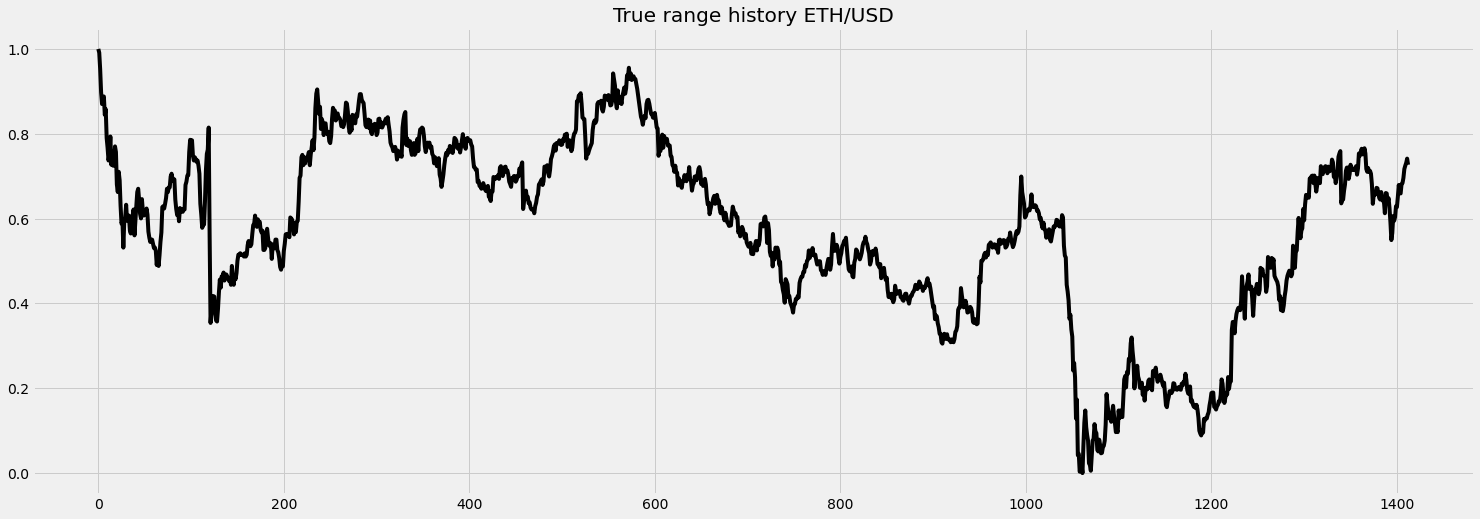

In [7]:
plt.figure(figsize=(23,8))
plt.title('True range history ETH/USD')
plt.plot(scaled_data, color='k')
plt.show()

In [8]:
#Create the training dataset
train_data = scaled_data[0:training_data_len, : ] #data NOT shuffled
timeStep = 60
#split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(timeStep, len(train_data)):
  x_train.append(train_data[i-timeStep:i, 0]) #previous 60 used as input
  y_train.append(train_data[i, 0]) #61st value for model to predict

In [9]:
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

[1.         0.99112098 0.95227525 0.89789123 0.87014428 0.8845727
 0.88790233 0.84461709 0.85793563 0.79023307 0.76692564 0.73695893
 0.75249723 0.79356271 0.72697003 0.75804661 0.72475028 0.72475028
 0.77025527 0.75693674 0.68035516 0.66259711 0.71032186 0.69034406
 0.63041065 0.58823529 0.59489456 0.53163152 0.59489456 0.60266371
 0.63263041 0.59489456 0.59711432 0.60710322 0.572697   0.56492786
 0.59933407 0.60710322 0.62153163 0.56048835 0.59711432 0.63041065
 0.66259711 0.67036626 0.64372919 0.61154273 0.60044395 0.64594895
 0.61931188 0.60710322 0.61376249 0.61043285 0.62375139 0.60932297
 0.56936737 0.55493896 0.54495006 0.55049945 0.55049945 0.54051054] 0.5305216426193118
[0.99112098 0.95227525 0.89789123 0.87014428 0.8845727  0.88790233
 0.84461709 0.85793563 0.79023307 0.76692564 0.73695893 0.75249723
 0.79356271 0.72697003 0.75804661 0.72475028 0.72475028 0.77025527
 0.75693674 0.68035516 0.66259711 0.71032186 0.69034406 0.63041065
 0.58823529 0.59489456 0.53163152 0.5948945

In [10]:
#Convert x_data and y_data to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
#reshape the data (1Dconv expects 3d [samples, timesteps, features])
x_train.shape
#samples is the total size of training set
#timestep is the sequence size used to predict next number
#features is just closing price, hence its 1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
x_train.shape

(1071, 60, 1)

In [12]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0039
Epoch 2/5
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0033
Epoch 3/5
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0028
Epoch 4/5
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0025
Epoch 5/5
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0025


In [15]:
#Create the testing dataset
test_data = scaled_data[training_data_len-timeStep:, :] # data from 80% to 100%
#create the datasets x_train and y_test
x_test = []
y_test = dataset[training_data_len:] #all the values we want model to predict
for i in range(timeStep, len(test_data)):
  x_test.append(test_data[i-timeStep:i, 0]) #the past 60 points

In [17]:
#convert data to numpy array
x_test = np.array(x_test)

In [18]:
#reshape x_test data into 3d
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(282, 60, 1)

In [24]:
#get the models preducted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #convert back to price

In [25]:
#get root mean squared error (RMSE) (lower is better)
rmse = np.sqrt(np.mean(((predictions-y_test)**2)))
rmse

0.3906455085044006

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


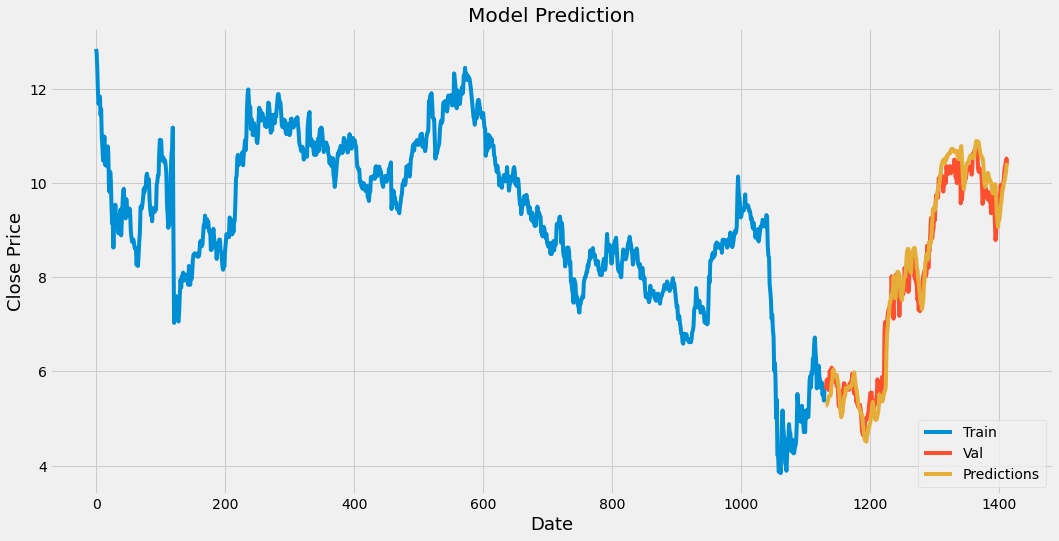

In [26]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# visualise the data
plt.figure(figsize=(16,8))
plt.title('Model Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()